# MNIST

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

**Note:** This experiment uses a variation of the traditional n-task model to incorporate learning between batches instead of applying gradients at the end of batches. The idea is that learning will be much faster and more stable while retaining the ability to switch on bad contexts.

In [16]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import tensorflow_datasets as tfds

import datetime
import numpy as np
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

# Import n-task
from keras_context.switches import TdErrorSwitch
from keras_context.callbacks import ContextLogger
from keras_context.flags import Verbosity
from keras_context.layers import Context
from keras_context.models import ContextModel
from keras_context.training import train, evaluate
from keras_context.utils import set_seed, idx_load

## Dataset

In [3]:
# Training images
training_images = idx_load("./datasets/mnist/train-images.idx3-ubyte")
training_images.shape

(60000, 28, 28)

In [4]:
# Training labels
training_labels = idx_load("./datasets/mnist/train-labels.idx1-ubyte")
training_labels.shape

(60000,)

In [5]:
testing_images = idx_load("./datasets/mnist/t10k-images.idx3-ubyte")
testing_images.shape

(10000, 28, 28)

In [6]:
# Training labels
testing_labels = idx_load("./datasets/mnist/t10k-labels.idx1-ubyte")
testing_labels.shape

(10000,)

In [7]:
# Normalize inputs
training_images = training_images / np.max(training_images)
testing_images = testing_images / np.max(testing_images)

___

## Experimentation

### 1. Even/Odd - Simple

This first task determines if the given image contains an even or odd number. This is the simplest of the MNIST experiments and will function as a proof-of-concept.

#### Dataset

In [8]:
def create_even_odd_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int) # Even/Odd

In [9]:
# Training Data
x_train = training_images
y_train_list = create_even_odd_labels(training_labels)

# Testing Data
x_test = testing_images
y_test_list = create_even_odd_labels(testing_labels)

#### Seeding

In [14]:
set_seed(5)

#### Model Creation

In [15]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = 2
switch_threshold = -0.5

# Model Architecture
inp = Input(x_train.shape[1:])
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu")(x)
x = Context(num_contexts, TdErrorSwitch(0.5, switch_threshold))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [16]:
cycles     = 2
epochs     = 10
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# Train the model
%time _, _, task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/20

[context_1] Switched context to 1
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 21/30

[context_1] Switched context to 0
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 31/40

[context_1] Switched context to 1
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
CPU times: user 5min 59s, sys: 3min 2s, total: 9min 1s
Wall time: 3min 51s


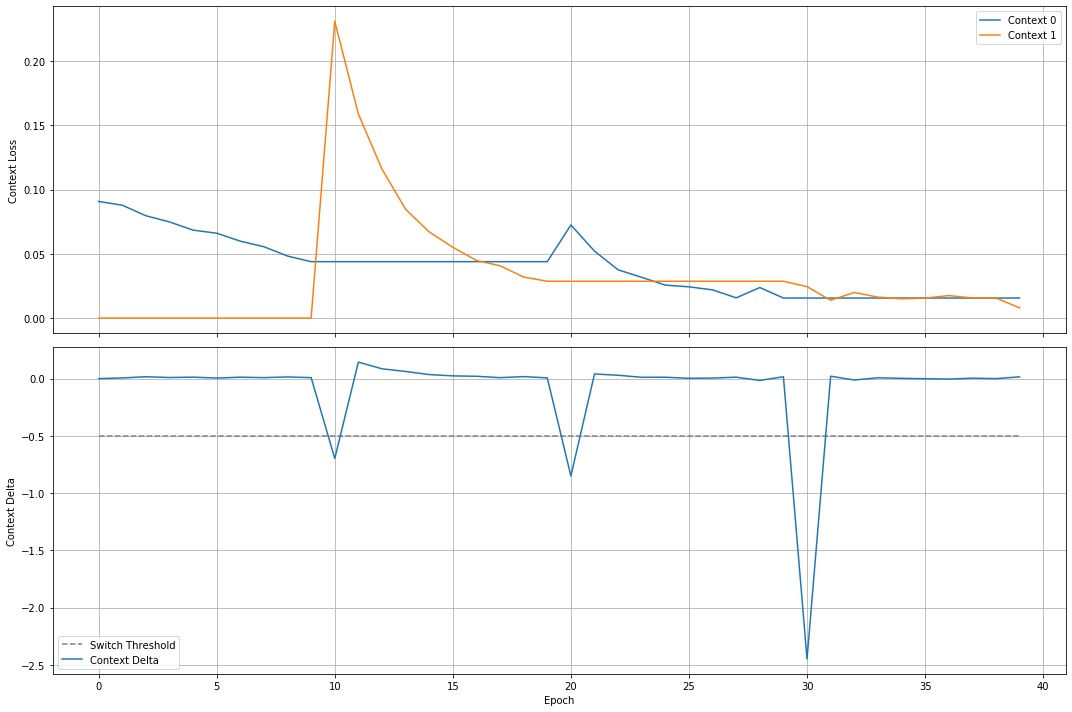

In [17]:
logger.plot(figsize=(15,10))

In [18]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 1.31 s, sys: 391 ms, total: 1.7 s
Wall time: 1.11 s


[{'loss': 0.07605643570423126, 'accuracy': 0.9857000112533569},
 {'loss': 0.07920639961957932, 'accuracy': 0.9869999885559082}]

___

### 2. [Static nTL]: Divisibility - CNN

This second task continues to recognize even/odd/divisible by 3 numbers, but this time using a convolutional neural network (CNN). Again, this task is relatively simple but will be a powerful proof-of-concept since the n-task model could be compatible with CNNs.

#### Dataset

In [19]:
def create_divisibility_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int), (labels % 3 == 0).astype(int) # Even/Odd/divisible by 3

In [20]:
# Training Data
x_train = training_images.reshape(training_images.shape + (1,))[:5000]
y_train_list = create_divisibility_labels(training_labels[:5000])

# Testing Data
x_test = testing_images.reshape(testing_images.shape + (1,))[:1000]
y_test_list = create_divisibility_labels(testing_labels[:1000])

#### Seeding

In [29]:
set_seed(5)

#### Model Creation

In [30]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = len(y_train_list)
switch_threshold = -0.005

# Model Architecture
inp = Input(x_train.shape[1:])
x = Conv2D(64, kernel_size=(8, 8), activation="relu")(inp)
x = Conv2D(128, (8, 8), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(hrr_size, activation="relu")(x)
x = Dropout(0.5)(x)
x = Context(num_contexts, TdErrorSwitch(0.5, switch_threshold))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [31]:
cycles     = 2
epochs     = 5
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# model.fit(x_train, y_train_list[0], epochs=epochs, shuffle=shuffle)

# Train the model
%time _, _, task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 6/10

[context_4] Switched context to 1
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/15

[context_4] Switched context to 2
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 16/20

[context_4] Switched context to 0
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 21/25

[context_4] Switched context to 1
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Epoch 26/30

[context_4] Switched context to 2
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
CPU times: user 2h 7s, sys: 3min 58s, total: 2h 4min 6s
Wall time: 11min 14s


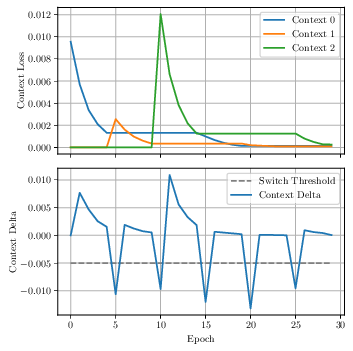

In [34]:
logger.plot(figsize=(5,5), savefile="graphs/mnist_static.pgf")

In [35]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 29.6 s, sys: 4.28 s, total: 33.9 s
Wall time: 3.09 s


[{'loss': 0.050898607820272446, 'accuracy': 0.9829999804496765},
 {'loss': 0.07184665650129318, 'accuracy': 0.9769999980926514},
 {'loss': 0.053294889628887177, 'accuracy': 0.9800000190734863}]

### 2. [Dynamic nTL]: Divisibility - CNN

This second task continues to recognize even/odd/divisible by 3 numbers, but this time using a convolutional neural network (CNN). Again, this task is relatively simple but will be a powerful proof-of-concept since the n-task model could be compatible with CNNs.

#### Dataset

In [36]:
def create_divisibility_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int), (labels % 3 == 0).astype(int) # Even/Odd/divisible by 3

In [37]:
# Training Data
x_train = training_images.reshape(training_images.shape + (1,))[:5000]
y_train_list = create_divisibility_labels(training_labels[:5000])

# Testing Data
x_test = testing_images.reshape(testing_images.shape + (1,))[:1000]
y_test_list = create_divisibility_labels(testing_labels[:1000])

#### Seeding

In [38]:
set_seed(5)

#### Model Creation

In [39]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = len(y_train_list)
switch_threshold = -0.005
add_threshold = -0.004

# Model Architecture
inp = Input(x_train.shape[1:])
x = Conv2D(64, kernel_size=(8, 8), activation="relu")(inp)
x = Conv2D(128, (8, 8), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(hrr_size, activation="relu")(x)
x = Dropout(0.5)(x)
x = Context(1, TdErrorSwitch(0.5, switch_threshold, add_threshold, num_contexts))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [41]:
cycles     = 2
epochs     = 5
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = ContextLogger()
callbacks = [logger]

# Train the model
%time _, _, task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 6/10

[context_5] Adding context 1

[context_5] Switched context to 1
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/15

[context_5] Adding context 2

[context_5] Switched context to 2
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 16/20

[context_5] Switched context to 0
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 21/25

[context_5] Switched context to 1
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Epoch 26/30

[context_5] Switched context to 2
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
CPU times: user 2h 3min 44s, sys: 4min 3s, total: 2h 7min 47s
Wall time: 11min 36s


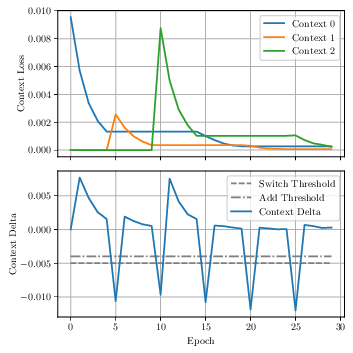

In [42]:
logger.plot(figsize=(5,5), savefile="graphs/mnist_dynamic.pgf")

In [43]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 29.1 s, sys: 4.83 s, total: 33.9 s
Wall time: 2.79 s


[{'loss': 0.05088748782873154, 'accuracy': 0.9800000190734863},
 {'loss': 0.05445132404565811, 'accuracy': 0.9789999723434448},
 {'loss': 0.04033994674682617, 'accuracy': 0.9890000224113464}]

 ### 3. [Static nTL]: Benchmark
 
 > ./mnist_task.py \<num_seeds> \<num_threads> \<num_training_images> \<num_testing_images> \<num_training_cycles> \<num_training_epochs>

In [5]:
%time !python3 ./mnist_task.py 10 12 5000 1000 4 5

2020-10-10 22:55:31.682385: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-10 22:55:31.748068: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-10 22:55:31.827330: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-10 22:55:31.901804: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-10 22:55:31.985093: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-10 22:55:32.067457: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
Training; Seed: 0 #ATRs 1
2020-10-10 22:55:32.159129: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
Training; Seed: 0 #ATRs 2
2020-10-10 22:55:32.245351: E tensorflow/stream_executor/cuda/cuda_driver

In [6]:
# Load the model results
with open("data/mnist.dat", 'rb') as f:
    data = pickle.load(f)

In [30]:
data[(3,3)][1]

[[{'loss': 0.07856177538633347, 'accuracy': 0.9789999723434448},
  {'loss': 0.5324907302856445, 'accuracy': 0.8399999737739563},
  {'loss': 0.04290420189499855, 'accuracy': 0.9869999885559082}],
 [{'loss': 0.038593024015426636, 'accuracy': 0.9919999837875366},
  {'loss': 0.03509717062115669, 'accuracy': 0.9929999709129333},
  {'loss': 0.03896085172891617, 'accuracy': 0.9829999804496765}],
 [{'loss': 0.04377788305282593, 'accuracy': 0.9869999885559082},
  {'loss': 0.04220806062221527, 'accuracy': 0.9869999885559082},
  {'loss': 7.0120625495910645, 'accuracy': 0.5170000195503235}],
 [{'loss': 0.9046441912651062, 'accuracy': 0.8159999847412109},
  {'loss': 4.748259544372559, 'accuracy': 0.5059999823570251},
  {'loss': 0.04444614425301552, 'accuracy': 0.984000027179718}]]

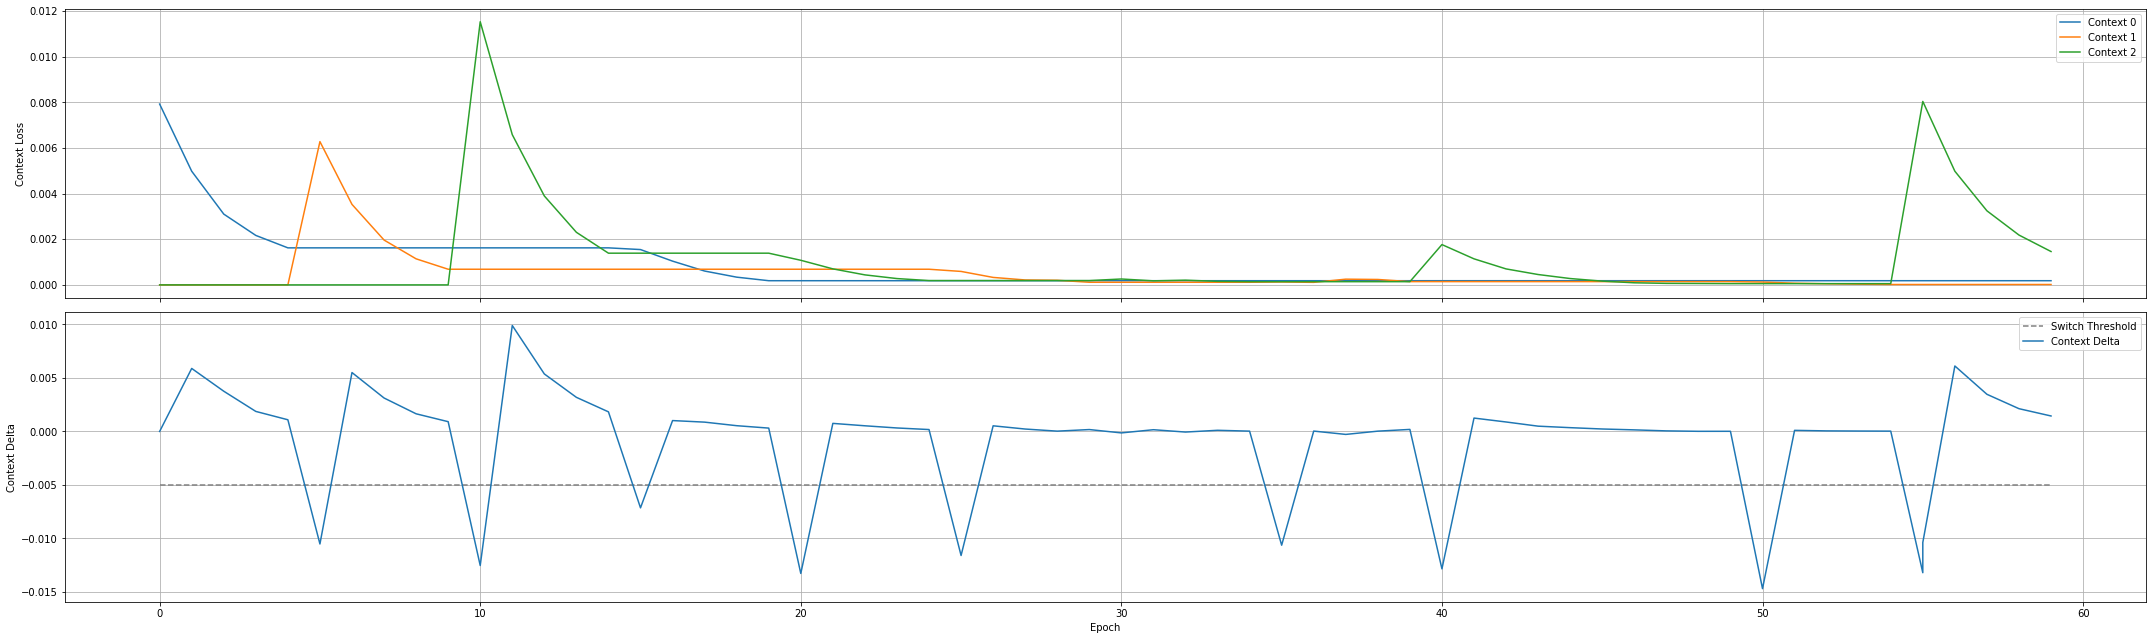

In [33]:
logger = ContextLogger()
logger.plots = data[(3,3)][0]
logger.plot()

In [7]:
# Organize the data
results = {}
for key in sorted(data.keys()):
    seed, num_contexts = key
    if num_contexts not in results:
        results[num_contexts] = []
    results[num_contexts].append(np.mean([[task["accuracy"] for task in cycle] for cycle in data[key][1]], axis=1))

In [8]:
# Convert to Numpy arrays
for key in results:
    results[key] = np.array(results[key])

In [13]:
results[3] # [num_atrs, seed, cycle_index]

array([[0.89233333, 0.98233332, 0.98033333, 0.988     ],
       [0.82000001, 0.83133334, 0.832     , 0.83266666],
       [0.955     , 0.963     , 0.983     , 0.98533334],
       [0.93533331, 0.98933331, 0.83033333, 0.76866666],
       [0.88833334, 0.98966666, 0.98933333, 0.99033332],
       [0.96499999, 0.97900001, 0.98966666, 0.75266665],
       [0.94733334, 0.98666666, 0.74666666, 0.977     ],
       [0.94966666, 0.98133334, 0.68266668, 0.90466666],
       [0.93266666, 0.98666666, 0.991     , 0.98866665],
       [0.89333334, 0.974     , 0.72633332, 0.75933333]])

In [18]:
boxplot_data = [results[key][:,-1] for key in results]

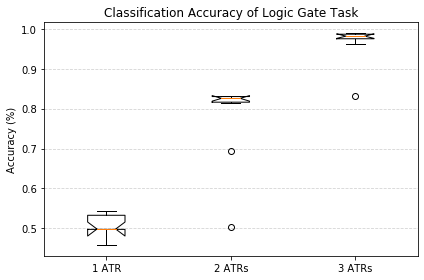

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
labels = ["1 ATR", "2 ATRs", "3 ATRs"]
x_pos = np.arange(1, len(labels)+1)
ax.grid(True, axis='y', linestyle='--', color='lightgrey', zorder=0)
# for x, label in enumerate(labels):
ax.boxplot(boxplot_data, notch=True, zorder=3)
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy of Logic Gate Task")
plt.tight_layout()
plt.savefig("graphs/mnist_accuracy.pgf")